# PUC Minas
## Pós Graduação em Ciência de Dados e Big Data (2018-2019)
## Trabalho de Conclusão de Curso
### Aluno: Igor Ribeiro Braga

Este notebook é relativo ao meu Trabalho de Conclusão de Curso em Ciência de Dados e Big Data. O título é **Séries Temporais de Receitas Orçamentárias da Prefeitura Municipal de João Pessoa e Predição de Valores Orçamentários**, neste trabalho o dataset foi baixado no site do [TCE-PB](http://tce.pb.gov.br/servicos/dados-abertos-do-sagres-tce-pb), especificamente a Tabela: Receita Orçamentária da Esfera Municipal. Para fazer o download diretamente, clique [aqui](https://dados.tce.pb.gov.br/TCE-PB-SAGRES-Receita_Orcamentaria_Esfera_Municipal.txt.gz). O dataset deve ser salvo na pasta `datasets` na pasta raiz deste notebook.

### Leitura dos dados e importação das bibliotecas utilizadas

Para iniciar o trabalho, o primeiro passo é fazer o downlad do *dataset* com os links disponibilizados acima e armazená-lo na pasta `datasets`. Assim, o documento pode ser lido sem maiores problemas.

No código abaixo, as importações das bibliotecas utilizadas e a definição de um método para facilitar a visualização dos valores em moeda Real (R$).

In [340]:
# Imports das bibliotecas utilizadas
import locale, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

# Define valores padrão para as figuras do matplotlib
rcParams['figure.figsize'] = 15, 6

# Função para converter Float em Currency
locale.setlocale(locale.LC_MONETARY, 'pt_BR.UTF-8')

def em_reais(valor):
    '''
    Função para exibir os valores em reais.
    '''
    return locale.currency(valor, grouping=True)

def show_value_counts(serie, column_desc=None, grain='Registers', 
                      size=None, total=None, title=None, height=10, index=None):
    '''
    Função que plota os value_counts de uma série.
    '''
    fig = plt.figure()
    fig.set_size_inches(15, height)

    ax1 = plt.subplot(1,1,1)

    serie = serie.value_counts().sort_values(ascending=True)

    if not total:
        total = serie.sum()
    
    corte = ''
    
    if (index):
        serie = serie.rename(index)
    
    if serie.index.dtype != 'object':
        if serie.index.dtype == 'float64':
            serie.index = serie.index.map(int)
        serie.index = serie.index.map(str)
    serie.index = serie.index.map(str)
    
    if size and len(serie) > size:
        serie = serie.sort_values(ascending=False)
        serie = serie[:size]
        serie = serie.sort_values(ascending=True)
        corte = ' ({} most frequents)'.format(size)
    
    if not title:
        if column_desc:
            column = column_desc
        else:
            column = serie.name
        title = "#{} by {}{}".format(grain, column, corte)
   
    ax1.barh(serie.index, serie, align='center', color='c', ecolor='black')
    percentage = serie/total*100
    number_distance = serie.max()*0.005
    
    for i, v in enumerate(serie):
        pct = locale.format('%.2f', percentage[i], True)
        ax1.text(v+number_distance , i-0.2, '{0:,} ({1}%)'.format(v, pct), color='k')
    ax1.set(title=title,
           xlabel='',
           ylabel='')
    sns.despine(left=True, bottom=True)

    plt.show()
    plt.show()

Para a leitura do dataset, foi definido os tipos das colunas **cd_ugestora**, **dt_mesano** e **dt_ano**.

In [341]:
# Definindo tipos das colunas antes de ler o dataset
columns_types = {'cd_ugestora': str, 'dt_mesano': str, 'dt_ano': int}

# Carrega os dados usando pandas
receitas = pd.read_csv('datasets/TCE-PB-SAGRES-Receita_Orcamentaria_Esfera_Municipal.txt',sep='|',dtype=columns_types,encoding='utf-8')

O dataset possui os dados de todas as entidade públicas da esfera municipal do estado da Paraíba, mas este estudo, apenas a **Prefeitura Municipal de João Pessoa** será utilizada. Portanto um filtro é aplicado e cria-se um novo Pandas Dataframe.

In [342]:
# Obtém todos os dados da Prefeitura Municipal de João Pessoa (cd_ugestora=201095)
pref_mun_joao_pessoa = receitas[receitas['cd_ugestora'] == '201095']

# Mostra informações sobre o dataset
pref_mun_joao_pessoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7712 entries, 486833 to 754495
Data columns (total 9 columns):
cd_ugestora              7712 non-null object
de_ugestora              7712 non-null object
dt_ano                   7712 non-null int64
cd_receitaorcug          7712 non-null int64
de_receitaorcug          7516 non-null object
tp_atualizacaoreceita    7712 non-null int64
de_atualizacaoreceita    7712 non-null object
vl_lancamentoOrc         7712 non-null float64
dt_mesano                7712 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 602.5+ KB


Acima, um resumo do dataset disponibilizado pelo Pandas. Nele, podemos verificar quais as colunas presentes, qual o tipo de dado cada coluna foi carregada e quantos objetos não nulos temos por coluna. Neste exemplo podemos verificar que a coluna **de_receitaorcug** possui valores nulos.

In [343]:
# Descrição do dataset
pref_mun_joao_pessoa.describe()

,dt_ano,cd_receitaorcug,tp_atualizacaoreceita,vl_lancamentoOrc
count,7712.000000,7.712000e+03,7712.000000,7.712000e+03
mean,2010.337915,1.514149e+08,1.196966,2.400637e+06
std,4.931977,1.116424e+09,0.594119,5.496038e+06
min,2003.000000,1.000000e+00,1.000000,0.000000e+00
25%,2006.000000,1.121250e+07,1.000000,2.645316e+04
50%,2010.000000,1.721010e+07,1.000000,2.672748e+05
75%,2015.000000,1.761000e+07,1.000000,1.587541e+06
max,2019.000000,9.517214e+09,5.000000,8.593407e+07


Com o método *describe* do Pandas obtemos informações sobre o dataset como:
1. count: Quantidade de registros
1. mean: Mediana
1. std: Desvio padrão
1. min: Valor mínimo
1. 25%: Primeiro quartil
1. 50%: Segundo quartil
1. 75%: Terceiro quartil
1. máx: Valor máximo

Abaixo são demonstrados quais são os tipos de receitas que uma prefeitura como a de João Pessoa recebe por mês.

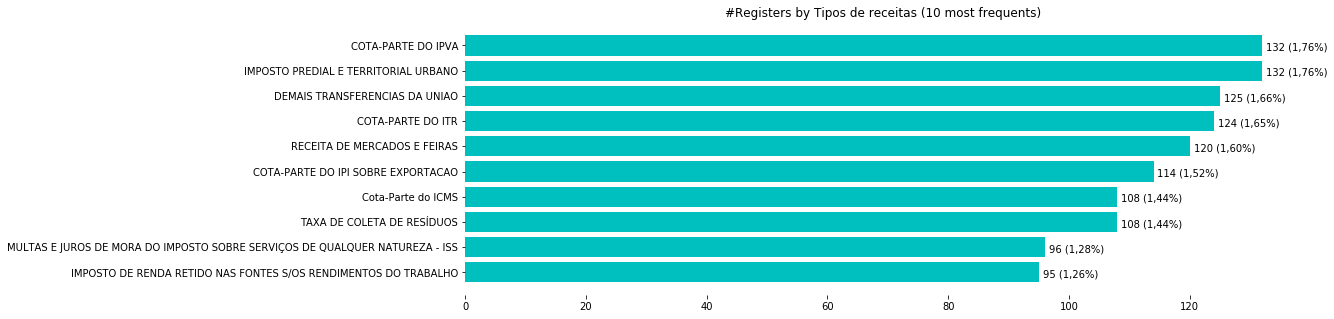

In [344]:
# Mostrar os tipos de receitas que o Município recebe.
# Aqui, os valores não são referentes ao total em receita, mas quantas vezes aparece no dataset.
show_value_counts(pref_mun_joao_pessoa['de_receitaorcug'],size=10,column_desc='Tipos de receitas',height=5)

Para o estudo, as entradas cujo o ano seja de 2019 serão descartadas, pois iremos trabalhar com os anos fechados de receitas recebidas. Para isso os índices das linhas que possuem o ano de 2019 são selecionadas para serem removidas do Dataframe.

In [345]:
# Seleção dos índices
indexAno2019 = pref_mun_joao_pessoa[pref_mun_joao_pessoa['dt_ano'] == 2019].index

# Remoção do Dataframe
pref_mun_joao_pessoa = pref_mun_joao_pessoa.drop(index=indexAno2019)
pref_mun_joao_pessoa.head()

,cd_ugestora,de_ugestora,dt_ano,cd_receitaorcug,de_receitaorcug,tp_atualizacaoreceita,de_atualizacaoreceita,vl_lancamentoOrc,dt_mesano
486833,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,702074.41,012004
486834,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,495731.36,022004
486835,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,684563.07,032004
486836,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,504136.72,042004
486837,201095,Prefeitura Municipal de João Pessoa,2004,11120800,"IMPOSTO SOBRE TRANSMISSAO -""INTER VIVOS"" DE BE...",1,Lançamento de receita,580640.06,052004


Após isso, é verificado se o dataset possui colunas com dados nulos, o que não ocorre no nosso caso.

In [346]:
# Identificando valores Nulos em colunas
pref_mun_joao_pessoa.isna().any()

cd_ugestora              False
de_ugestora              False
dt_ano                   False
cd_receitaorcug          False
de_receitaorcug          False
tp_atualizacaoreceita    False
de_atualizacaoreceita    False
vl_lancamentoOrc         False
dt_mesano                False
dtype: bool

Analisando outras entidade públicas no dataset, identiquei que algumas delas possuiam datas com meses incoerentes, como `13` por exemplo. Assim, vou verificar na coluna **dt_mesano** e pegar os 2 primeiros dígitos do meses (formato MMYYYY) e listar para verificar se algum possui esse dado incoerente.

In [347]:
# Certificando se possuem meses incoerentes
pref_mun_joao_pessoa.dt_mesano.str.slice(0,2).value_counts()

12    673
07    646
08    638
10    637
06    634
11    630
05    626
09    626
04    618
01    605
03    604
02    579
Name: dt_mesano, dtype: int64

Nesse caso os dados só possuem valores de meses válidos.

Sabendo que os dados da coluna **dt_mesano** estão coerentes, vou mudar o tipo de dado da coluna pata `datetime`.

In [348]:
# Convertendo a coluna Mês/Ano em Datetime
pref_mun_joao_pessoa['dt_mesano'] = pd.to_datetime(pref_mun_joao_pessoa['dt_mesano'], format='%m%Y')

Com o dataset suficientemente validado, podemos iniciar o processo de análise dos dados.

### Análise inicial do dados e obtenção de informações do dataset

Para iniciar o estudo do dataset, alguns questionamentos vieram a mente:

1. Quais os valores recebidos por ano?
1. Quais os valores recebidos por mês/ano?
1. Quais são as top 5 tipos de receita que mais geram receita ao Município?
1. Como se comporta a série temporal do total de receitas mês/ano do Município (2003-2018)?
1. Como se fazer forecasting de valores orçamentários baseados no dataset?
1. Utilizando o Prophet do Facebook para gerar predições da série temporal

Bem, vamos começar pela primeira pergunta:

#### 1. Quais os valores recebidos por ano?

Para responder a essa pergunta, vamos primeiro remover as colunas que não agregam informação para isso em um novo Dataframe.

In [349]:
# Criar novo dataframe apenas com os dados que importam
receitas_por_ano = pref_mun_joao_pessoa.drop(columns=['cd_ugestora','de_ugestora','cd_receitaorcug','de_receitaorcug','tp_atualizacaoreceita','de_atualizacaoreceita','dt_mesano'])
receitas_por_ano.head()

,dt_ano,vl_lancamentoOrc
486833,2004,702074.41
486834,2004,495731.36
486835,2004,684563.07
486836,2004,504136.72
486837,2004,580640.06


Aqui temos as várias entradas de receitas por mês dos anos de 2003 a 2018. No momento, queremos esses valores agrupados e somados por ano.

In [350]:
# Agrupar e calcular a soma da coluna vl_lancamentoOrc
receitas_por_ano['total'] = receitas_por_ano.groupby('dt_ano').transform('sum')
receitas_por_ano = receitas_por_ano.drop(columns=['vl_lancamentoOrc'])

In [351]:
# Removendo duplicatas e ordenando pelo ano
receitas_por_ano.drop_duplicates(keep='first', inplace=True)
receitas_por_ano.sort_values(by=['dt_ano'],ascending=True,inplace=True)

In [352]:
# Definindo o ano como índice
receitas_por_ano.set_index('dt_ano',inplace=True)
receitas_por_ano.head()

,total
dt_ano,
2003,4.269491e+08
2004,5.309502e+08
2005,6.393762e+08
2006,7.121140e+08
2007,8.121067e+08


Agora podemos exibir o primeiro gráfico, o de totais de receitas por ano.

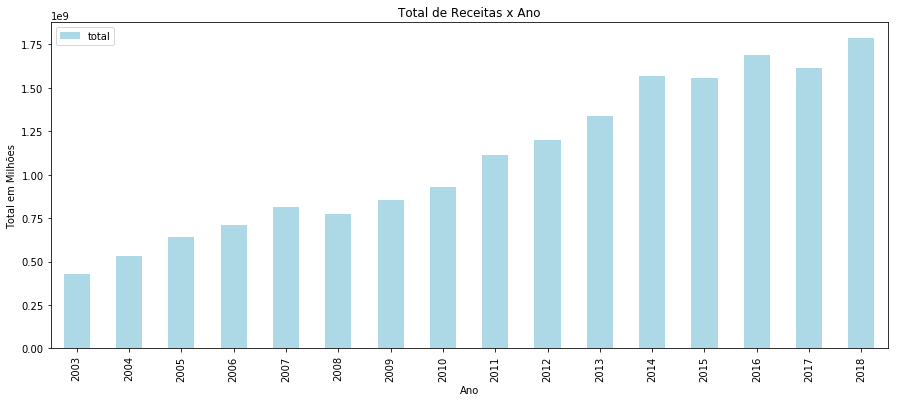

In [353]:
# Plotando gráfico: Total de recebimentos x Ano
ax = receitas_por_ano.plot(kind='bar',color='lightblue',title='Total de Receitas x Ano')

ax.set_ylabel('Total em Milhões')
ax.set_xlabel('Ano')

plt.show()

Como demonstrado no gráfico acima, o ano de 2018 foi o ano que mais acumulou receitas desde 2003. Abaixo temos um resumo de informações sobre o dados do agrupamento desses valores, como os quartis(25%, 50% e 75%), a média (mean), o desvio padrão (std) e os valores máximos e mínimos.

Mais abaixo, temos um gráfico bloxplot que evidencia essas informação graficamente.

In [354]:
# Informações sobre o desvio padrão, valores máximo e mínimo e os percentiles.
receitas_por_ano.describe()

,total
count,1.600000e+01
mean,1.096098e+09
std,4.466808e+08
min,4.269491e+08
25%,7.600471e+08
50%,1.019998e+09
75%,1.559869e+09
max,1.787108e+09


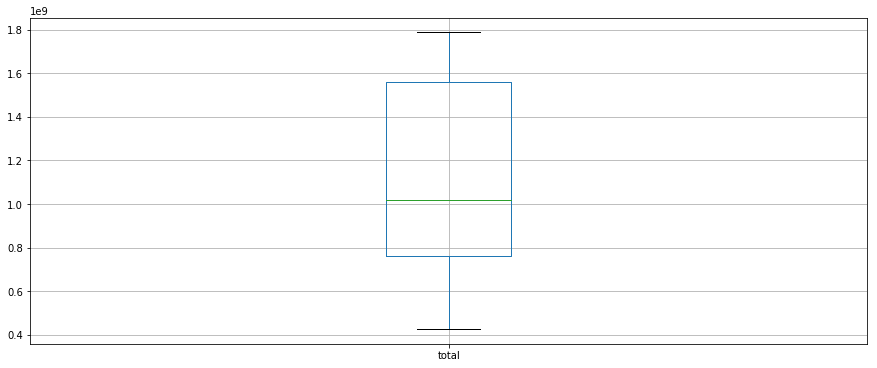

In [355]:
# Gráfico bolxplot dos totais de receitas recebidas entre os anos de 2003 e 2018
receitas_por_ano.boxplot()

In [356]:
# Ano que ocorreu o maior valor total de receitas
receitas_por_ano.idxmax(axis=0)

total    2018
dtype: int64

In [357]:
# Maior valor total de receitas recebidos em um mesmo ano
em_reais(receitas_por_ano.loc[2018]['total'])

'R$ 1.787.107.723,33'

Com o gráfico fica mais evidente a proporção dos valores recebidos por ano, e com isso pudemos identificar o ano que mais acumulou receita e o valor total acumulado.

**2018: R$ 1.787.108.000,00**

#### 2. Quais os valores recebidos por mês/ano?

A análise aqui será similar a da pergunta anterior, mas levando em consideração da coluna **dt_mesano** ao invés da **dt_ano**.

In [358]:
# Criar novo dataframe apenas com os dados que importam
receitas_por_mes_ano = pref_mun_joao_pessoa.drop(columns=['cd_ugestora','de_ugestora','cd_receitaorcug','de_receitaorcug','tp_atualizacaoreceita','de_atualizacaoreceita','dt_ano'])
receitas_por_mes_ano.head()

,vl_lancamentoOrc,dt_mesano
486833,702074.41,2004-01-01
486834,495731.36,2004-02-01
486835,684563.07,2004-03-01
486836,504136.72,2004-04-01
486837,580640.06,2004-05-01


In [359]:
# Agrupar e calcular a soma da coluna vl_lancamentoOrc
receitas_por_mes_ano['total'] = receitas_por_mes_ano.groupby('dt_mesano').transform('sum')
receitas_por_mes_ano = receitas_por_mes_ano.drop(columns=['vl_lancamentoOrc'])

In [360]:
# Removendo duplicatas
receitas_por_mes_ano.drop_duplicates(keep='first', inplace=True)
receitas_por_mes_ano.sort_values(by=['dt_mesano'],ascending=True,inplace=True)

In [361]:
# Definindo o mês/ano como índice
receitas_por_mes_ano.set_index('dt_mesano',inplace=True)
receitas_por_mes_ano.head()

,total
dt_mesano,
2003-01-01,46923205.80
2003-02-01,31463697.81
2003-03-01,34147830.15
2003-04-01,29138516.65
2003-05-01,38139457.19


Como os dados tratados aqui agora são os meses do ano, a visualização do gráfico utilizando barras não fica bom pois serão plotados os 190 meses e as informações sobre os meses no eixo X ficarão sobrepostos. Portanto vou criar um gráfico em linha. Isso também irá nos ambientar para nosso futuro estudo sobre a série temporal orçamentária.

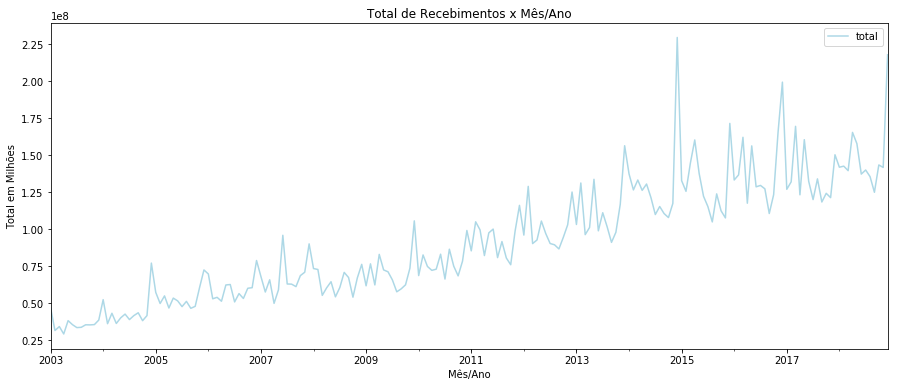

In [362]:
# Plotando gráfico: Total de recebimentos x Mês/Ano
ax = receitas_por_mes_ano.plot(kind='line',color='lightblue',title='Total de Recebimentos x Mês/Ano')

ax.set_ylabel('Total em Milhões')
ax.set_xlabel('Mês/Ano')

plt.show()

In [363]:
# Dados estatísticos
receitas_por_mes_ano.describe()

,total
count,1.920000e+02
mean,9.134154e+07
std,3.953522e+07
min,2.913852e+07
25%,6.025553e+07
50%,8.585041e+07
75%,1.231781e+08
max,2.294779e+08


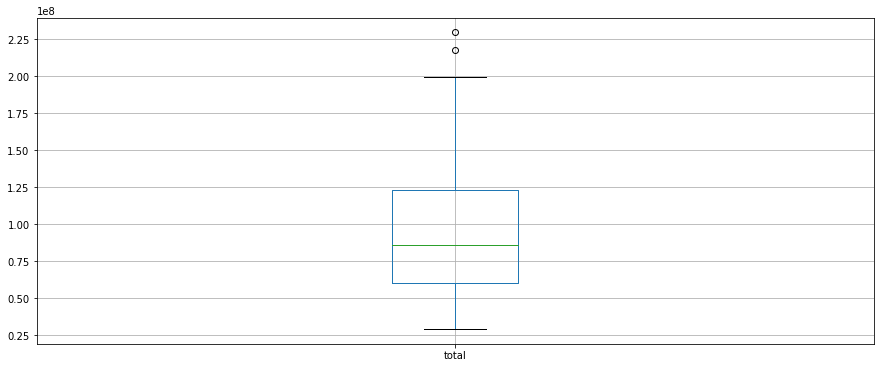

In [364]:
# Gráfico Bloxplot com os quartis, outliers, valores mínimos e máximos (desconsiderando os outliers)
receitas_por_mes_ano.boxplot()

Direfentemente do gráfico bloxpot criado com os totais por ano, neste gráfico são mostrados 2 valores considerados **outliers**. São exatamente os dois picos de valores mostrados no gráfico anterior. São os meses de dezembro de 2014 e dezembro de 2018, como evidenciados abaixo:

In [365]:
# 2 meses com maior volume de receitas
receitas_por_mes_ano.total.nlargest(n=2)

dt_mesano
2014-12-01    2.294779e+08
2018-12-01    2.177838e+08
Name: total, dtype: float64

In [366]:
# Valor formatado em reais de dezembro de 2014
em_reais(receitas_por_mes_ano.loc['2014-12-01']['total'])

'R$ 229.477.921,05'

In [367]:
# Valor formatado em reais de dezembro de 2018
em_reais(receitas_por_mes_ano.loc['2018-12-01']['total'])

'R$ 217.783.839,04'

#### 3. Quais são as top 5 tipos de receita que mais geram receita ao Município?

#### 4. Como se comporta a série temporal do total de receitas mês/ano do Município (2003-2018)?


In [31]:
# Tendência, Sazonalidade e Variação
# Plot ACF e PACF vai indicar se a série é estacionária.

#### 5. Como se fazer forecasting de valores orçamentários baseados no dataset?

#### 6. Utilizando o Prophet do Facebook para gerar predições da série temporal

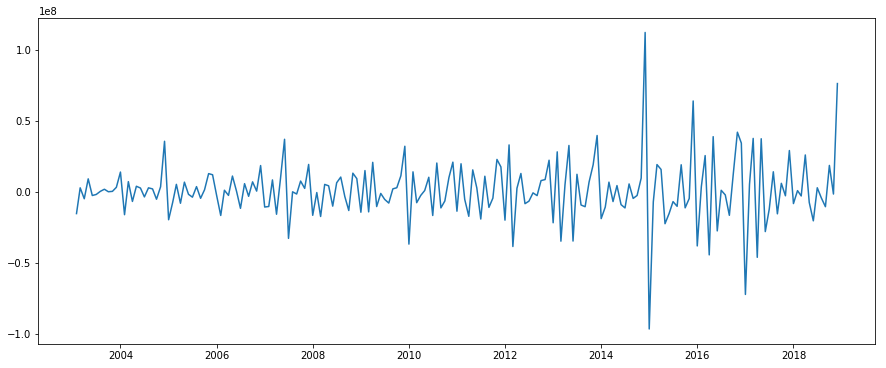

In [53]:
# Aplicando diferenciação para obter um gráfico mais estacionário
ts_log_diff = receitas_por_mes_ano - receitas_por_mes_ano.shift()
plt.plot(ts_log_diff)

In [33]:
# Mostrar teste de Dickey-Fuller (adf test), valor p deve ser inferior a 5%, caso não seja, realizar nova diferenciação

from statsmodels.tsa.stattools import adfuller

result = adfuller(receitas_por_mes_ano.total)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.028282
p-value: 0.956130
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [34]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

result = adfuller(np.log(np.log(receitas_por_mes_ano.total)))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.995724
p-value: 0.035296
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [35]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

result = adfuller(np.log(receitas_por_mes_ano.total))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.799238
p-value: 0.058383
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


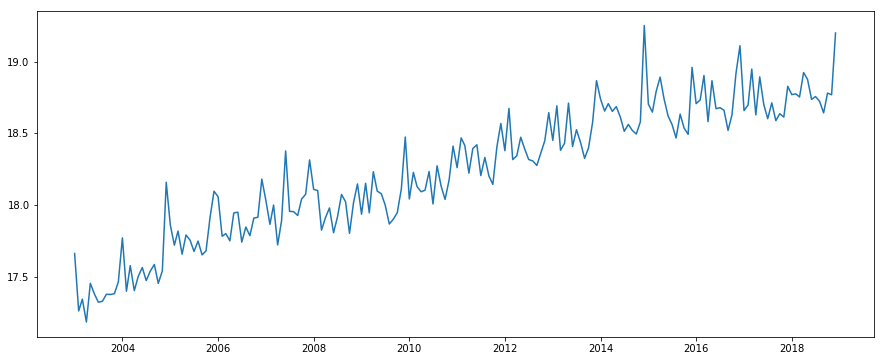

In [54]:
import numpy as np

# Melhorando a variação
ts_log = np.log(receitas_por_mes_ano)
plt.plot(ts_log)

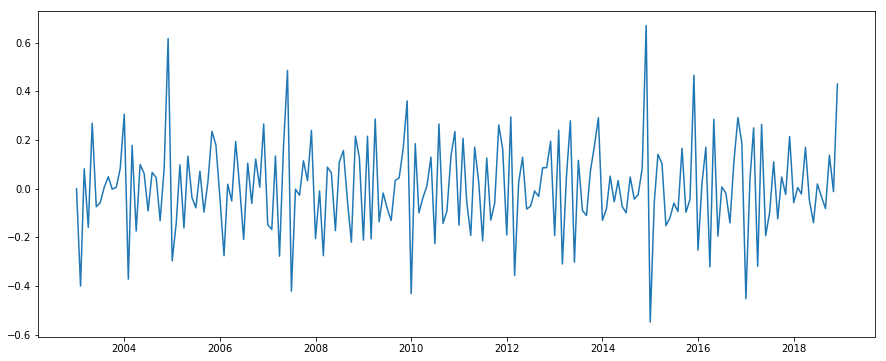

In [55]:
# Aplicando diferenciação para obter um gráfico mais estacionário
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff = ts_log_diff.fillna(0)
plt.plot(ts_log_diff)

In [38]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

result = adfuller(ts_log_diff.total)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -12.384845
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [39]:
receitas_por_mes_ano.total.autocorr()

0.8504240316671062

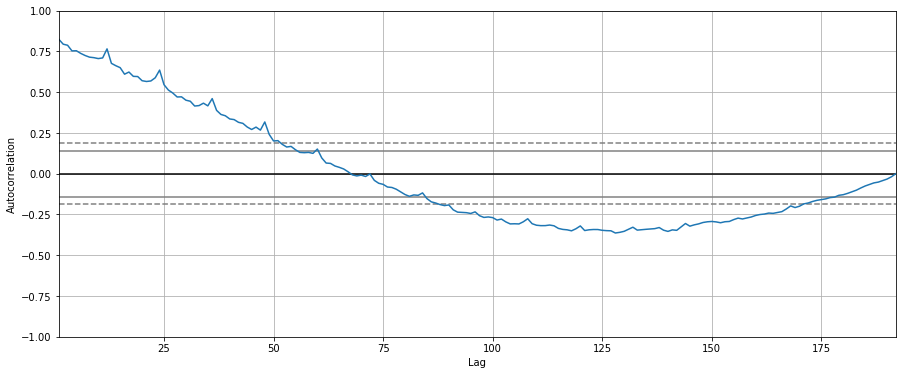

In [56]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(receitas_por_mes_ano.total)

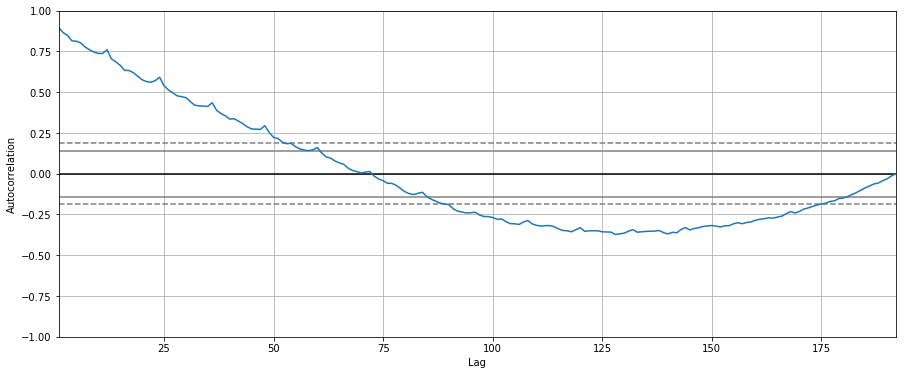

In [57]:
autocorrelation_plot(ts_log.total)

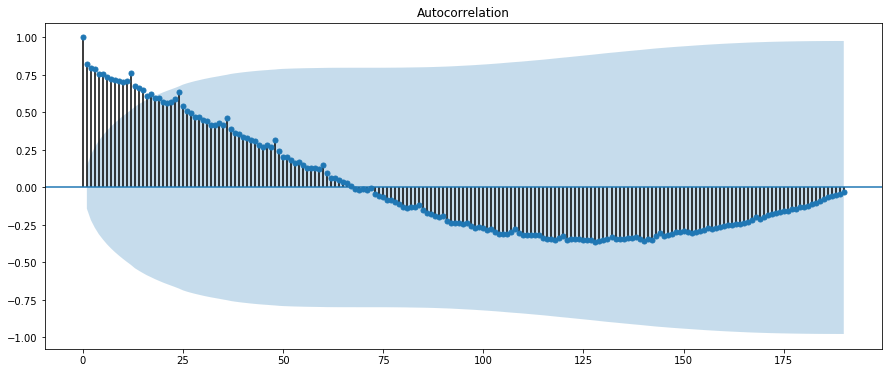

In [58]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(receitas_por_mes_ano.values.squeeze(), lags=190)
plt.show()

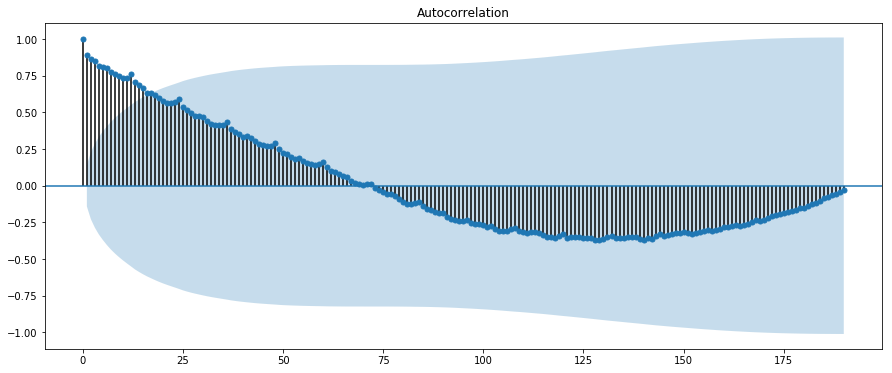

In [59]:
sm.graphics.tsa.plot_acf(ts_log.values.squeeze(), lags=190)
plt.show()

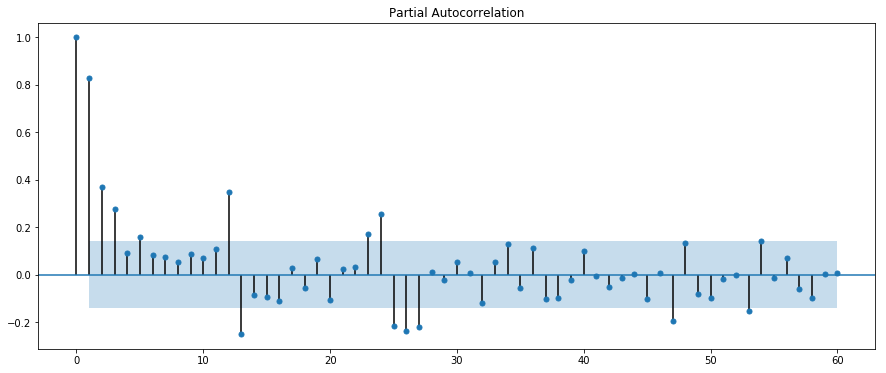

In [60]:
sm.graphics.tsa.plot_pacf(receitas_por_mes_ano.values.squeeze(), lags=60)
plt.show()

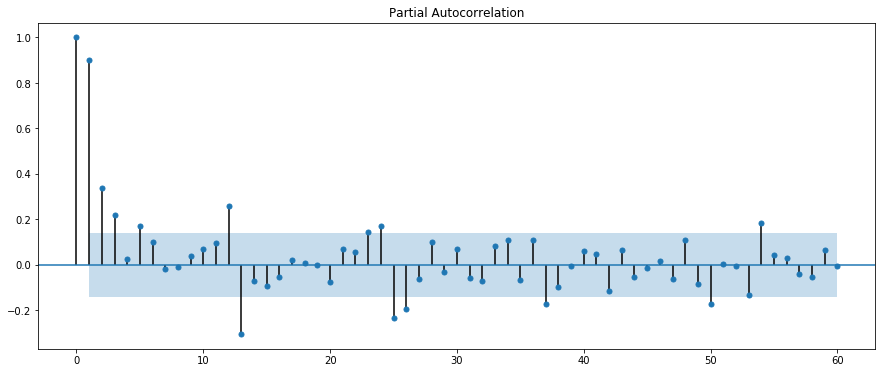

In [61]:
sm.graphics.tsa.plot_pacf(ts_log.values.squeeze(), lags=60)
plt.show()

In [46]:
# Plotar esse mesmo gráfico num bloxplot, plotando os ciclos
# Em R -> boxplot(AirPassengers~cycle(AirPassengers)) para ajudar a identificar a sazonalidade no ciclo.
# ACF - Auto correlation factor, mostra se o gráfico é estacionário; Se houver uma queda, ela indica se a série
# é estacionária, se ocilar não é;
# Partial ACF -> Vai mostrar os picos dentro da séria

# Testar se a nova série é estacionária, rodar o teste ADF (Augmented Dickey-Fuller Test);

# Nesse gráfico mostra
# - Uma tendência positiva, mostrando uma séria temporal crescente;
# - Isso demostra uma série não estacionária;
# - Mostra uma aparente sazonalidade com uma variação relevante nos anos de 2015 e 2017;
# - Deve-se, portanto, calcular o ruído para ver se a média dessa ocilação positiva e negativa tende a 0;
# - Seve-se também aplicar técnicas para estacionar a série;

# - Para séries não estacionárias, no modelo ARIMA, utilizar 1 no nível de autoregressão já seria o suficiente;
'''
Etapas

- Tornar a séria estacionária - Por diferenciação
- Controlar a variação (por transformação logarítmica, a mais simples)
- Determinar se os termos autorregressivos (AR) ou de médias móveis (MA) são necessários
- Teste do Modelo, Menor AIC
- Analisar os resíduos estacionários, com média zero e variância constante = Modelo correto
'''

'\nEtapas\n\n- Tornar a séria estacionária - Por diferenciação\n- Controlar a variação (por transformação logarítmica, a mais simples)\n- Determinar se os termos autorregressivos (AR) ou de médias móveis (MA) são necessários\n- Teste do Modelo, Menor AIC\n- Analisar os resíduos estacionários, com média zero e variância constante = Modelo correto\n'